# 0K String method on the Müller-Brown Potential
## Zilin Song, 2021 May 3, 
#### Ph.D. student, SMU Chemistry (Theoretical)
---

## Import some libraries

In [1]:
import math
import scipy.interpolate as intpol
import matplotlib.pyplot as plt
from matplotlib import cm

~~import numpy as np~~
###### (Not numpy this time.)
---
## I. The Müller potential

#### a. Build the Müller potential

In [2]:
class MullerPotential():
    """
    Müller-Brown potential.
    
    Note that some bad values of (x, y) would cause an error.
    Mostly in math.exp(). (some range related issue).
    """
    
    # M-B potential constants
    AA = [-200., -100.,  -170.,  15., ]
    aa = [  -1.,   -1.,   -6.5,  0.7, ]
    bb = [   0.,    0.,    11.,  0.6, ]
    cc = [ -10.,  -10.,   -6.5,  0.7, ] 
    xx = [   1.,    0.,   -0.5,  -1., ]
    yy = [   0.,   0.5,    1.5,   1., ]

    @classmethod
    def energy(self, x, y, ):
        '''
        Computes the energy of point (x, y) on the Müller-Brown potential.

        Parameters
        ----------
        x: float
            x-coordinate of point.
        y: float
            y-coordinate of point.

        Returns
        -------
        energy: float
            Returns the energy value of the point (x, y) as a float number.
        '''
        ene = 0
        
        # M-B potential is the sum of 4 terms
        for i in range(4):
            ene += self.AA[i] * math.exp(
                self.aa[i] * (x - self.xx[i])**2 + 
                self.bb[i] * (x - self.xx[i]) * (y - self.yy[i]) + 
                self.cc[i] * (y - self.yy[i])**2
            )
        return ene
    
    @classmethod
    def force(self, x, y, ):
        '''
        Computes the force on the point (x, y) using the Müller-Brown potential.

        Parameters
        ----------
        x: float
            x-coordinate of point.
        y: float
            y-coordinate of point.

        Returns
        -------
        (force_x, force_y): (float, float)
            Returns the force vector of the point (x, y) as (dx, dy) vector.
            Note the force is always the negative of gradient.
        '''
        force_x = 0
        force_y = 0
        
        # M-B potential is the sum of 4 terms
        for i in range(4):
            u = self.AA[i] * math.exp(
                        self.aa[i] * (x - self.xx[i])**2 +
                        self.bb[i] * (x - self.xx[i]) * (y - self.yy[i]) +
                        self.cc[i] * (y - self.yy[i])**2 
            )
            
            # note that force must be negative gradient
            force_x -= (u * (self.aa[i]*2*(x - self.xx[i]) + self.bb[i]*(y - self.yy[i])))
            force_y -= (u * (self.cc[i]*2*(y - self.yy[i]) + self.bb[i]*(x - self.xx[i])))
        
        return (force_x, force_y)
    
    @classmethod
    def plot_contourf(self, minx=-1.5, maxx=1.3, miny=-0.5, maxy=2.3, xpoints=101, ypoints=101):
        '''
        Plot the Müller-Brown potential as a contour map.
        
        Parameters
        ----------
        minx, maxx, miny, maxy: float
            The range of potential surface.
        xpoints, ypoints: int
            The number of grid points on each dimension.
            Must be positive.
            
        Returns
        -------
        ax: Matplotlib.Axis()
            On which the potential contour map was plotted.
        '''
        # build the x-y grid dimensions
        # reinvent the np.linspace()
        x_list = [minx + (maxx-minx) / (xpoints-1) * i for i in range(xpoints)]
        y_list = [miny + (maxy-miny) / (ypoints-1) * i for i in range(ypoints)]
            
        # compute potential at each grid point.
        # reinvent np.meshgrid()
        v = []
        for i in range(len(y_list)):
            vy = []
            
            for j in range(len(x_list)):
                vi = self.energy(x_list[j], y_list[i], )
                
                if vi > 250:
                    vi = 250
                    
                vy.append(vi)
                
            v.append(vy)
            
        fig, ax = plt.subplots(figsize=(3,3), dpi=300, )
        cs = ax.contourf(x_list, y_list, v, 200 )
        return fig, ax
        

#### b. Visualize the Müller Potential

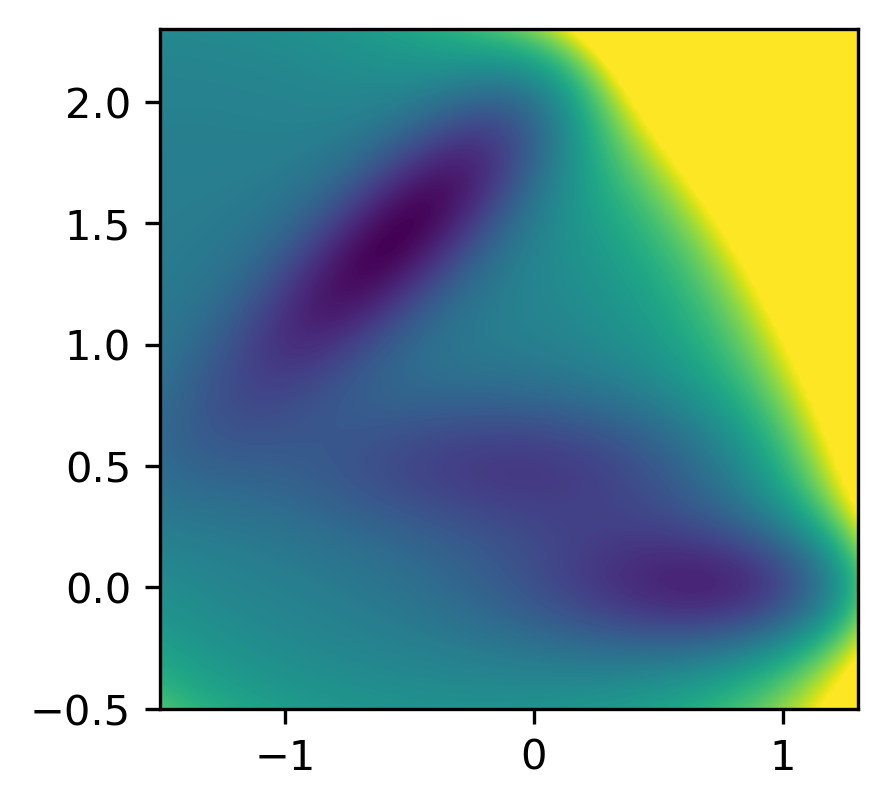

In [3]:
mp=MullerPotential()
figure, axis = mp.plot_contourf()

---
## II. Make initial string.
#### a. Initialize the string.

> Note that the string is defined as a tuple ([x], [y])

The coordinates of the initial string:
x: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y: [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]


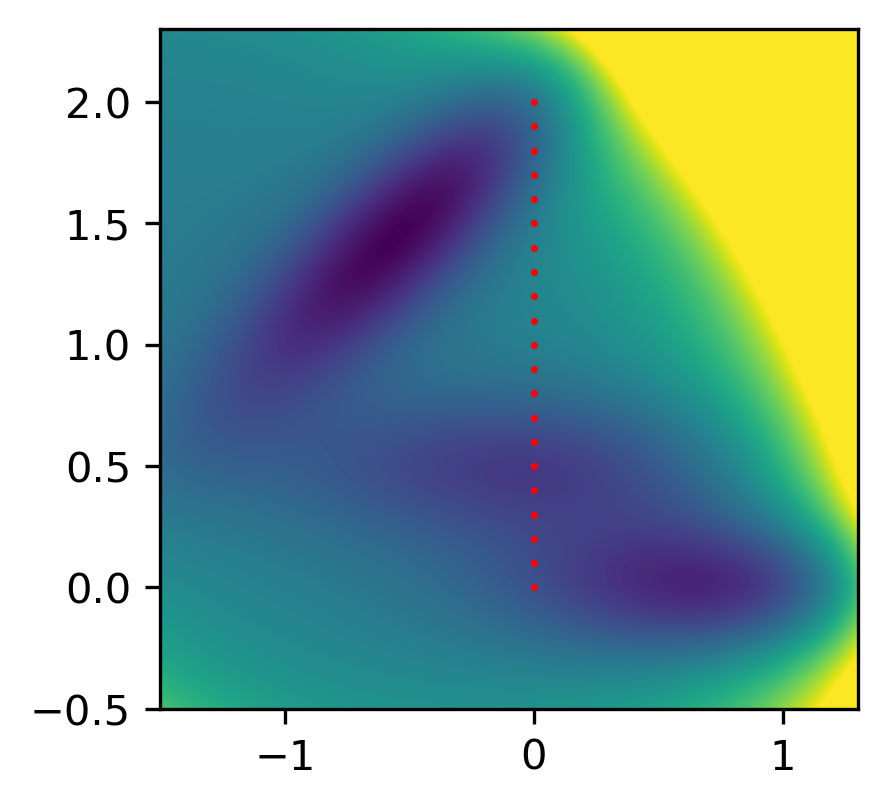

In [4]:
# Make the initial string using linear interpolation.

# 1. first the endpoints.
x1, y1 = -1., 0.
xn, yn =  1., 2.

# 2. make string with {nrep} images.
nrep = 21

# 3. make the initial string list,
#    again re-invent np.linspace()
string = (
    [ 0                                     for i in range(nrep) ],  # all the x's,
    [ round(y1 + (yn-y1) / (nrep-1) * i, 2) for i in range(nrep) ],  # all the y's
)

# 4. take a look at the initial string
## as coordinates
print('The coordinates of the initial string:')
print('x: {0}'.format(string[0]))
print('y: {0}'.format(string[1]))

## on the Müller potential
axis.scatter(string[0], string[1], s=0.5, c='r' )
figure

---
## III. Key functions implementing the string method.
> 1. string_curve_len:  computing the curve length.
> 
> 2. string_reparam_spline:  re-parametrize/update the string, return the updated string and the gradients (along the string).
>    
> 3. string_evolve_sd:  evolve the string using Steepest Decend.

In [5]:
def string_curve_len(string):
    '''
    This method obtains the total curve length by image-wise integration and 
    the arc-length of adjacent string images. Be aware that the image coordinates 
    are NOT normalized in this method. Normalization happens in string_reparam_spline.
    
    Parameters
    ----------
    string: tuple, (x, y)
        The input string to reparametrize.
        
    Returns
    -------
    curv_len: float
        Total length of string by image-wise integration;
    image_coors: list(float)
        All arc-lengths b/w adjacent string images.
        Note that len(arc_lens) equals to len(string)-1.
    '''
    curv_len = 0
    img_coors = []
    
    for i in range(0, len(string[0])):
        
        if i == 0:
            arclen = 0
        
        else:    
            # coordinates of adjacent string images
            x0 = string[0][i-1]
            x1 = string[0][i]
        
            y0 = string[1][i-1]
            y1 = string[1][i]
        
            # compute arc-length of adjacent images
            arclen = math.sqrt((x1-x0)**2 + (y1-y0)**2)
        
        curv_len += arclen
        img_coors.append(curv_len)
    
    return (curv_len, img_coors)
    
    
def string_reparam_spline(string):
    '''
    This method reparametrizes the string by cubic spline interpolation.
    
    Note that interpolation happens on "each dimension": n -> X; n -> Y..., NOT X -> Y.
    Therefore the x and y's on the new string is the compatible to their original space.
    
    Will also return the updated string images and the gradients of the string(along the curve).
    The gradients are used to project the potential force on to the unit normal vector of the string.
    
    Parameters
    ----------
    string: tuple, (x, y)
        The input string to reparametrize.
        
    Returns
    -------
    new_string: tuple, (x, y)
        The output, reparametrized string.
    '''
    # obtain the total curve length, 
    curvlen, img_coors = string_curve_len(string)
    
    # normalized image coordinates
    norm_img_coors = [img_coor/curvlen for img_coor in img_coors]
    
    # interpolate x and y, respectively
    intpol_x = intpol.CubicSpline(norm_img_coors, string[0])
    intpol_y = intpol.CubicSpline(norm_img_coors, string[1])
    
    # build the new string using interpolated value
    new_x = [ 0 + 1 / (len(string[0]) - 1) * i for i in range(len(string[0])) ]
    new_y = [ 0 + 1 / (len(string[1]) - 1) * i for i in range(len(string[1])) ]
    new_string_x = intpol_x(new_x)
    new_string_y = intpol_y(new_y)
    
    # obtain the gradient (tangen vectors) along the string at each image.
    new_string_gradient_x = intpol_x(new_x, 1)
    new_string_gradient_y = intpol_y(new_y, 1)
    
    new_string = (new_string_x, new_string_y, )
    gradients = (new_string_gradient_x, new_string_gradient_y)
    
    return new_string, gradients
    
def string_evolve_sd(string, potential, string_gradients, timestep = 0.0002, ):
    '''
    Evolve each string image with Steepest Decent.
    
    X(n+1) = X(n) - delta_t * delta_X(n)
    
    some shorthands:
        tv:  the tangent vector (not unit);
        utv: unit tangent vector;
        nv:  the normal vector (not unit);
        unv: unit normal vector.
    
    Parameters
    ----------
    string: tuple, ([x], [y])
        The input string to reparametrize.
    potential: class,
        Must implement the force(x, y) method, 
        here it's the Müller Potential.
        Note that force = -V(gradient).
    string_gradients: list[(x, y)]
        This is the unit_tangent_vectors along the parametrized string, 
        The Forces should be projected to "unit_normal_vectors", 
        which are perpendicular to the string gradients
    timestep: float,
        The time step to perform steepest decent, the delta_t.
        Large values lead to unstability.
    
    Returns
    -------
    new_string: tuple, ([x], [y])
        The output, reparametrized string.
    '''
    new_x = []
    new_y = []
    for i in range(len(string[0])):
        # force
        force_x, force_y = potential.force(string[0][i], string[1][i])
        
        # tangent vector (gradient) along the string (forwardly)
        tv_x, tv_y = string_gradients[0][i], string_gradients[1][i]
        
        # project the force onto the plane that is perpendicular to the unit tangent vector (this case the unit normal vector).
        force_proj_unv_x = force_x - (tv_x * force_x + tv_y * force_y) / (tv_x * tv_x + tv_y * tv_y) * tv_x
        force_proj_unv_y = force_y - (tv_x * force_x + tv_y * force_y) / (tv_x * tv_x + tv_y * tv_y) * tv_y

        # if is end-point images, do ordinary SD using original force.
        if i == 0 or i == len(string[0])-1:
            new_x.append(string[0][i] + timestep*force_x)
            new_y.append(string[1][i] + timestep*force_y)
            
        # else if other images, do SD using force projected on unit normal vector
        else:
            new_x.append(string[0][i] + timestep*force_proj_unv_x)
            new_y.append(string[1][i] + timestep*force_proj_unv_y)
    
    new_string = (new_x, new_y)
    return new_string

---
## IV. Test our 0KSM
#### Note that reparametrization is done at every step -> this is not FTSM.
> Unlike FTSM, in 0KSM, Evolving string on PES without re-parametrization will only delay convergence.

The coordinates of the initial string:
x: [0.6234698788944032, 0.48953955848037084, 0.3625724958257088, 0.274704977226947, 0.20671348212533122, 0.12740887876061452, 0.0018884216880670978, -0.13165471657733863, -0.2657845741579232, -0.40002859468971996, -0.5339172908011414, -0.6650855554588625, -0.7847774250540032, -0.8834008762485718, -0.9585767103943097, -0.9864129645888586, -0.9287693815563327, -0.8410844097975201, -0.747711406902733, -0.6531154177125412, -0.5581443660853828]
y: [0.028039624376334314, 0.040199494764543486, 0.08451027361000625, 0.18631270124286617, 0.302336255774643, 0.41093437758455714, 0.4591932480311566, 0.47500766685013596, 0.4846755354044464, 0.49259444408536124, 0.5051728167429684, 0.5348457048640335, 0.5961787986786486, 0.6876174288075881, 0.7991450184194421, 0.9307620540027823, 1.052291072997914, 1.154253121152291, 1.2510292932627045, 1.3466106991254831, 1.441805186344509]


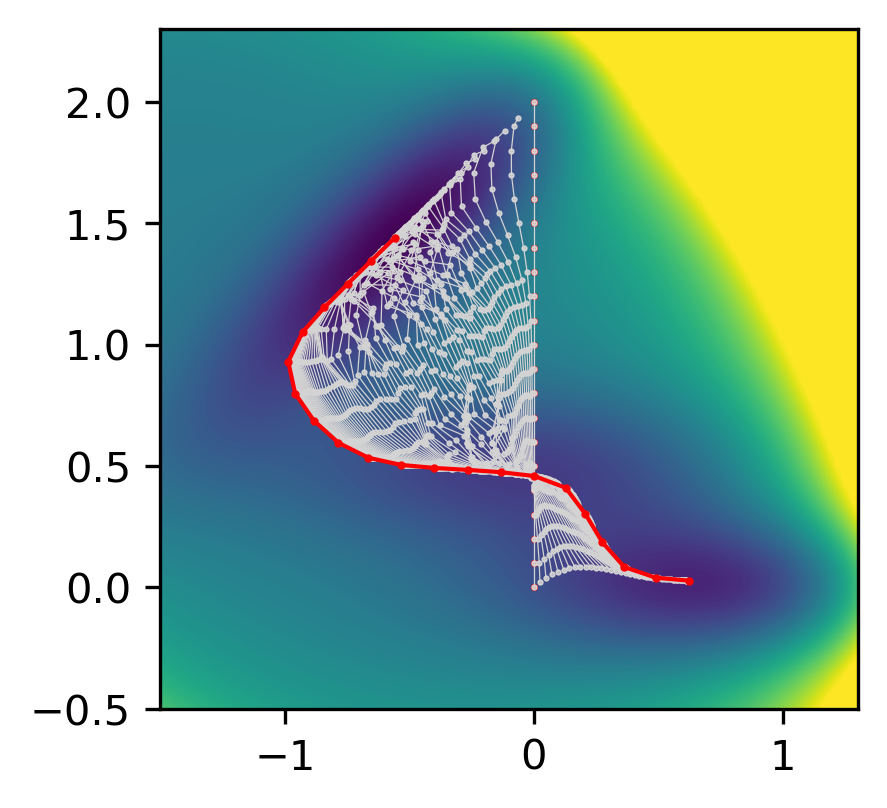

In [6]:
# run {nsteps} steps of 0KSM on Müller potential surface.
# reparametrize every {repa_step} steps.

nstep     = 100
repa_step = 1
plot_step = 1

for istep in range(nstep):
    
    # reparametrize, including the first step.
    # plot the re-parametrized instantanous string, in red.
    if istep % repa_step == 0:
        new_string, gradients = string_reparam_spline(string)
        
    if istep % plot_step == 0:
        axis.plot(string[0], string[1], 'o-', lw=0.3, markersize=0.5, c='lightgrey' )
    
    
    # evolve the string and plot it in gray
    new_string = string_evolve_sd(new_string, mp, gradients, )
    
    
    # keep the loop going
    string = new_string
    
# plot the final string, in black
axis.plot(string[0], string[1], 'o-', lw=1, markersize=1, c='r' )

# take a look at the final string
## as coordinates
print('The coordinates of the initial string:')
print('x: {0}'.format(string[0]))
print('y: {0}'.format(string[1]))

figure

## References
1. K. Müller, and L. D. Brown, Theoret. Chim. Acta 53, 1 (1979);
2. W. E, W. Ren, and E. Vanden-Eijnden, Phys. Rev. B. 66, 052301 (2002);
3. W. E, W. Ren, and E. Vanden-Eijnden, J. Phys. Chem. B. 109, 14 (2005);
4. W. E, W. Ren, and E. Vanden-Eijnden, J. Chem. Phys. 126, 164103 (2007).